In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import drive.MyDrive.Proyecto.project_utils as pu
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

In [3]:
BASEPATH = "/content/drive/MyDrive/Proyecto/Datasets/"

train_df = pd.read_pickle(BASEPATH + "train_40ms_win.pkl")
val_df = pd.read_pickle(BASEPATH + "val_40ms_win.pkl")

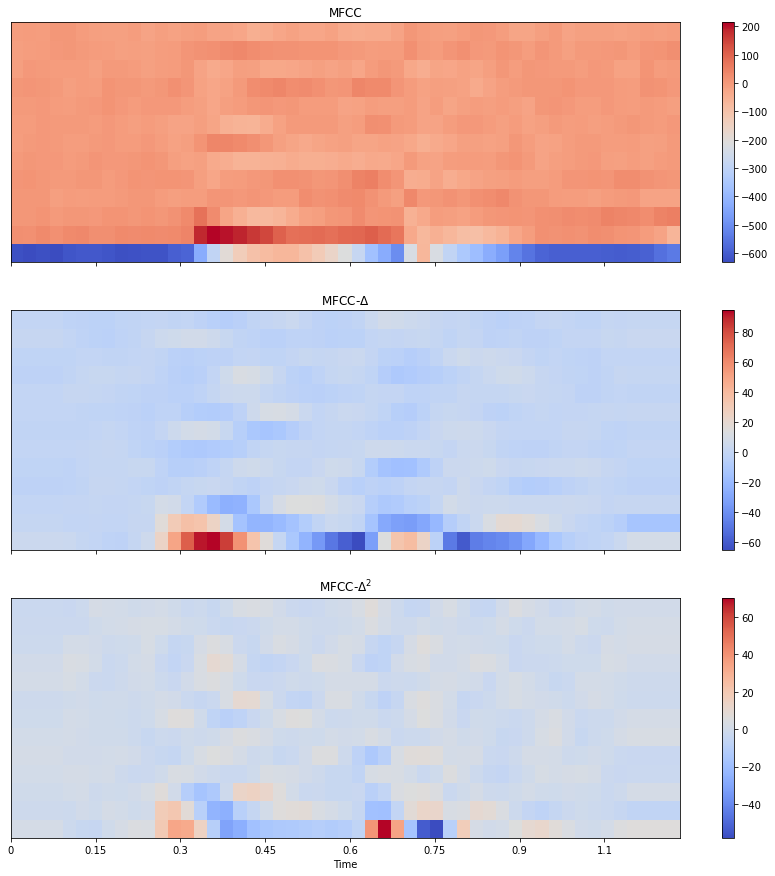

In [6]:
pu.visualize_row(train_df.iloc()[0])

In [7]:
train_df = pu.oversample(train_df)

In [8]:
train_df.head()

,signal,mfcc,delta,delta2,label
0,"[0.00022023513, 0.00018079297, 0.00014135083, ...","[[-661.8671, -662.1164, -664.1109, -661.7965, ...","[[0.37605286, 0.37605286, 0.37605286, 0.376052...","[[0.5643064, 0.5643064, 0.5643064, 0.5643064, ...",up
1,"[-0.00039074678, 0.00096937397, 0.00053062534,...","[[-647.0698, -670.43536, -681.7522, -684.9083,...","[[-5.0499835, -5.0499835, -5.0499835, -5.04998...","[[4.615121, 4.615121, 4.615121, 4.615121, 1.67...",up
2,"[-0.07351167, -0.07367135, -0.07878125, -0.078...","[[-218.00465, -210.77176, -209.47296, -213.376...","[[0.48524967, 0.48524967, 0.48524967, 0.485249...","[[-2.0424554, -2.0424554, -2.0424554, -2.04245...",up
3,"[0.00034855894, -0.0003158092, 0.0003011041, -...","[[-584.8661, -594.8874, -583.1455, -584.3925, ...","[[24.1243, 24.1243, 24.1243, 24.1243, 54.69186...","[[18.62828, 18.62828, 18.62828, 18.62828, 35.8...",up
4,"[-5.846186e-05, -5.846186e-05, -5.846186e-05, ...","[[-662.59766, -662.59766, -662.59766, -662.597...","[[0.001299177, 0.001299177, 0.001299177, 0.001...","[[-0.0002179827, -0.0002179827, -0.0002179827,...",up


In [9]:
max_length = max(
    train_df.mfcc.apply(lambda x: x[0].size).max(),
    train_df.delta.apply(lambda x: x[0].size).max(),
    val_df.mfcc.apply(lambda x: x[0].size).max(),
    val_df.delta.apply(lambda x: x[0].size).max()
)

In [10]:
categories, c2i, i2c = pu.get_categories(train_df)

In [11]:
train_df, test_df = train_test_split(train_df, test_size=0.15)

In [12]:
train_data = pu.SCData(train_df, categories, c2i, i2c, max_length)
test_data = pu.SCData(test_df, categories, c2i, i2c, max_length)
valid_data = pu.SCData(val_df, categories, c2i, i2c, max_length)

100%|██████████| 9981/9981 [00:03<00:00, 2537.84it/s]


In [13]:
BATCH_SIZE = 64

In [14]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)

# Modelos

In [15]:
import drive.MyDrive.Proyecto.models as mdls

In [16]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHANNELS = 39
NUM_CLASSES = len(categories)
pu.iniciar_semillas()

In [ ]:
windows = [20, 40, 80, 120]
bidirecc = [False, True]
data= [
    # ( lr, epochs, hs, n_lay, class)
    (2e-4, 100, 256, 1, mdls.RNN),
    (2e-4, 100, 64, 2, mdls.LSTM),
    (2e-4, 100, 64, 2, mdls.GRU),
]
BATCH_SIZE = 64

for window in windows:
  train_df = pd.read_pickle(BASEPATH + f'train_{window}ms_win.pkl')
  val_df = pd.read_pickle(BASEPATH + f'val_{window}ms_win.pkl')
  train_df = pu.oversample(train_df)
  max_length = max(
      train_df.mfcc.apply(lambda x: x[0].size).max(),
      train_df.delta.apply(lambda x: x[0].size).max(),
      val_df.mfcc.apply(lambda x: x[0].size).max(),
      val_df.delta.apply(lambda x: x[0].size).max()
  )
  categories, c2i, i2c = pu.get_categories(train_df)
  train_df, test_df = train_test_split(train_df, test_size=0.15)
  
  train_data = pu.SCData(train_df, categories, c2i, i2c, max_length)
  test_data = pu.SCData(test_df, categories, c2i, i2c, max_length)
  valid_data = pu.SCData(val_df, categories, c2i, i2c, max_length)

  train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
  test_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
  valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)
  for bidirec in bidirecc:
    for datum in data:
      lr, epochs, hs, n_lay, cls = datum
      name = cls.__name__
      desc = f'_{window}ms_{bidirec}'
      model_name = f'{name}_{desc}'
      model = cls(hs, n_lay, NUM_CLASSES, CHANNELS, max_length)
      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)  

      train_loss_evolution, train_acc_evolution, val_acc_evolution, val_loss_evolution = pu.train_complete(model, criterion, optimizer, epochs, train_loader, test_loader, model_name, DEVICE)

      model = cls(hs, n_lay, NUM_CLASSES, CHANNELS, max_length)
      model.load_state_dict(torch.load(f'{model_name}.pt'))



In [18]:
name = "RNN"
learning_rate = 2e-4
epochs = 100

hidden_size = 256
num_layers = 1

model = mdls.RNN(hidden_size, num_layers, NUM_CLASSES, CHANNELS, max_length)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)  

train_loss_evolution, train_acc_evolution, val_acc_evolution, val_loss_evolution = pu.train_complete(model, criterion, optimizer, epochs, train_loader, test_loader, name, DEVICE)

RNN_model = mdls.RNN(hidden_size, num_layers, NUM_CLASSES, CHANNELS, max_length)
RNN_model.load_state_dict(torch.load(f'{name}.pt'))


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 3.353 | Train Acc: 8.44%
	 Val. Loss: 3.353 |  Val. Acc: 8.35%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 3.074 | Train Acc: 13.00%
	 Val. Loss: 3.074 |  Val. Acc: 13.05%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 2.890 | Train Acc: 17.44%
	 Val. Loss: 2.889 |  Val. Acc: 17.32%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 2.877 | Train Acc: 18.15%
	 Val. Loss: 2.876 |  Val. Acc: 18.04%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 3.034 | Train Acc: 13.85%
	 Val. Loss: 3.034 |  Val. Acc: 13.88%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 2.672 | Train Acc: 20.83%
	 Val. Loss: 2.672 |  Val. Acc: 20.91%
Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 2.796 | Train Acc: 19.74%
	 Val. Loss: 2.797 |  Val. Acc: 19.60%
Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 2.553 | Train Acc: 23.92%
	 Val. Loss: 2.554 |  Val. Acc: 23.74%
Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 2.530 | Train Acc: 24.84%
	 Val. Loss: 2.529 |  Val. Acc: 25.07%
Epoch: 10 | Epoch Time: 0m 1s


<All keys matched successfully>

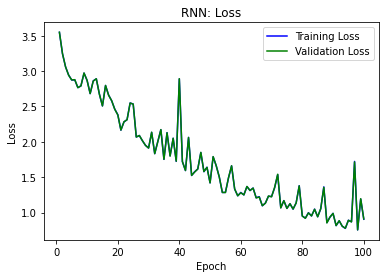

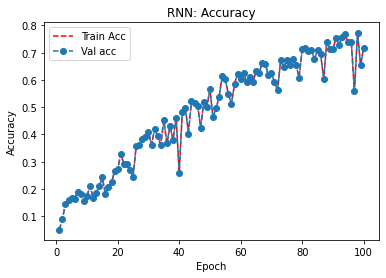

In [ ]:
pu.plot_train_evo(train_loss_evolution, val_loss_evolution, train_acc_evolution, val_acc_evolution, name, )

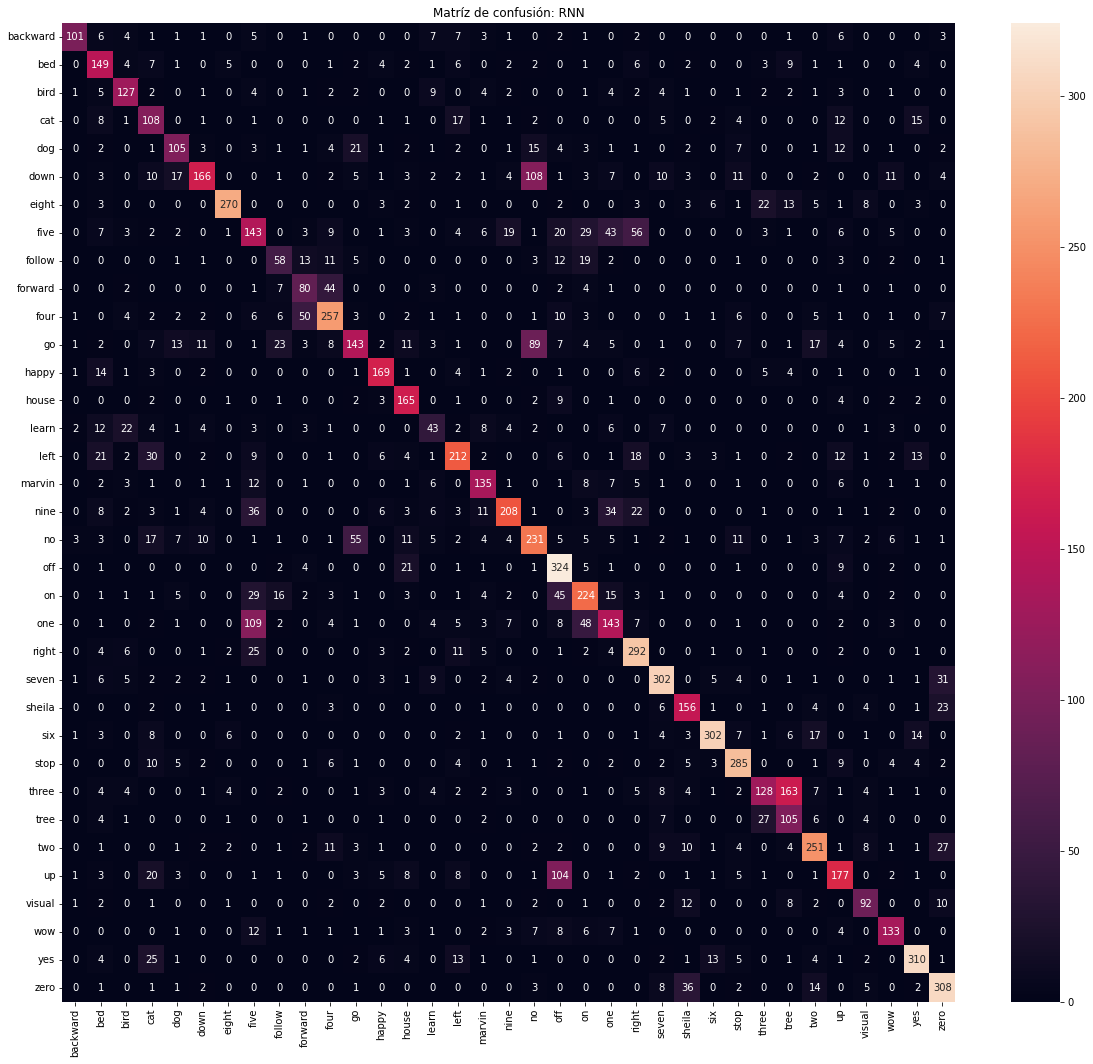

In [ ]:
project_utils.plot_conf_matrix(RNN_model, valid_loader, categories, name, DEVICE)

In [ ]:
name = "LSTM"
learning_rate = 2e-4
epochs = 100

hidden_size = 64
num_layers = 2

model = models.LSTM(hidden_size, num_layers, NUM_CLASSES, CHANNELS, max_length)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)  

train_loss_evolution, train_acc_evolution, val_acc_evolution, val_loss_evolution = project_utils.train_complete(model, criterion, optimizer, epochs, train_loader, test_loader, name, DEVICE)

LSTM_model = models.LSTM(hidden_size, num_layers, NUM_CLASSES, CHANNELS, max_length)
LSTM_model.load_state_dict(torch.load(f'{name}.pt'))

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.329 | Train Acc: 6.24%
	 Val. Loss: 3.328 |  Val. Acc: 6.31%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.184 | Train Acc: 9.26%
	 Val. Loss: 3.185 |  Val. Acc: 9.07%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 3.061 | Train Acc: 10.86%
	 Val. Loss: 3.060 |  Val. Acc: 11.02%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 2.942 | Train Acc: 15.16%
	 Val. Loss: 2.942 |  Val. Acc: 15.21%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 2.870 | Train Acc: 18.50%
	 Val. Loss: 2.870 |  Val. Acc: 18.43%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 2.723 | Train Acc: 22.09%
	 Val. Loss: 2.725 |  Val. Acc: 22.02%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 2.590 | Train Acc: 25.87%
	 Val. Loss: 2.591 |  Val. Acc: 25.82%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 2.480 | Train Acc: 30.15%
	 Val. Loss: 2.479 |  Val. Acc: 30.15%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.387 | Train Acc: 31.81%
	 Val. Loss: 2.386 |  Val. Acc: 31.91%
Epoch: 10 | Epoch Time: 0m 0s
	T

<All keys matched successfully>

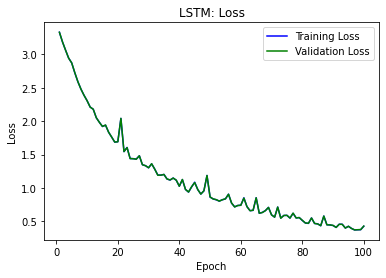

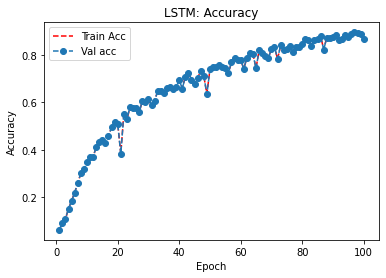

In [ ]:
project_utils.plot_train_evo(train_loss_evolution, val_loss_evolution, train_acc_evolution, val_acc_evolution, name)

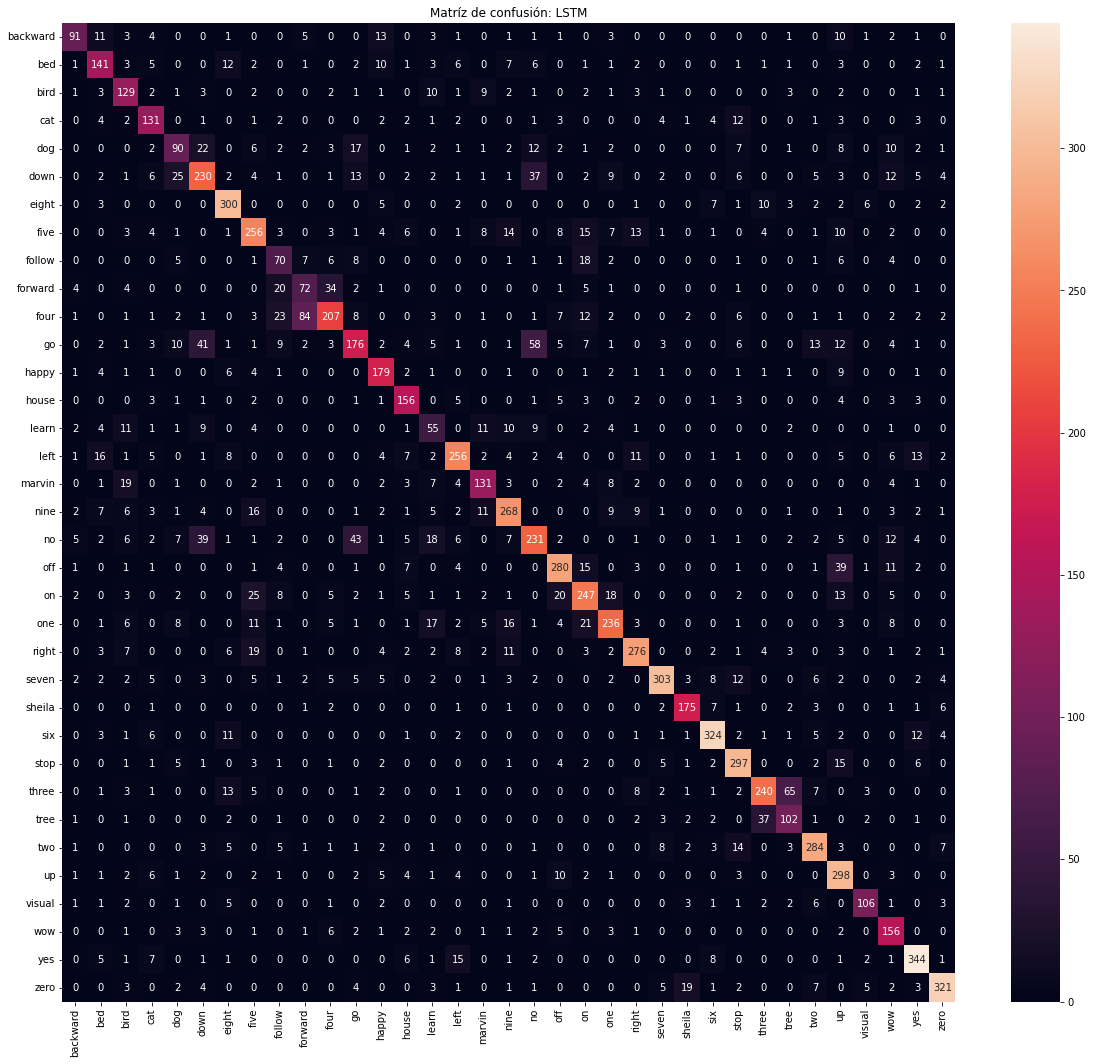

In [ ]:
project_utils.plot_conf_matrix(LSTM_model, valid_loader, categories, name, DEVICE)

In [ ]:
name = "GRU"
learning_rate = 2e-4
epochs = 100

hidden_size = 64
num_layers = 2

model = models.GRU(hidden_size, num_layers, NUM_CLASSES, CHANNELS, max_length)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)  

train_loss_evolution, train_acc_evolution, val_acc_evolution, val_loss_evolution = project_utils.train_complete(model, criterion, optimizer, epochs, train_loader, valid_loader, name, DEVICE)

GRU_model = models.GRU(hidden_size, num_layers, NUM_CLASSES, CHANNELS, max_length)
GRU_model.load_state_dict(torch.load(f'{name}.pt'))

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 3.369 | Train Acc: 6.70%
	 Val. Loss: 3.369 |  Val. Acc: 6.63%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 3.036 | Train Acc: 13.51%
	 Val. Loss: 3.038 |  Val. Acc: 13.49%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 2.874 | Train Acc: 16.62%
	 Val. Loss: 2.875 |  Val. Acc: 16.70%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 2.773 | Train Acc: 18.92%
	 Val. Loss: 2.773 |  Val. Acc: 18.94%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 2.661 | Train Acc: 22.79%
	 Val. Loss: 2.661 |  Val. Acc: 22.79%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 2.534 | Train Acc: 26.05%
	 Val. Loss: 2.532 |  Val. Acc: 26.11%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 2.430 | Train Acc: 28.65%
	 Val. Loss: 2.431 |  Val. Acc: 28.53%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 2.330 | Train Acc: 31.33%
	 Val. Loss: 2.330 |  Val. Acc: 31.22%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 2.239 | Train Acc: 34.43%
	 Val. Loss: 2.240 |  Val. Acc: 34.28%
Epoch: 10 | Epoch Time: 0m 0s


<All keys matched successfully>

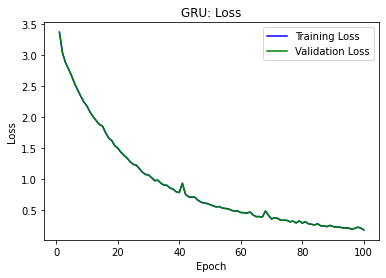

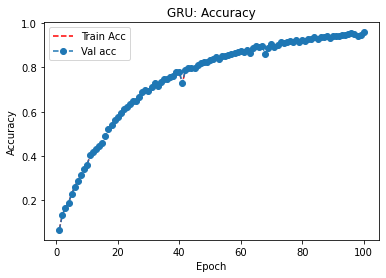

In [ ]:
project_utils.plot_train_evo(train_loss_evolution, val_loss_evolution, train_acc_evolution, val_acc_evolution, name)

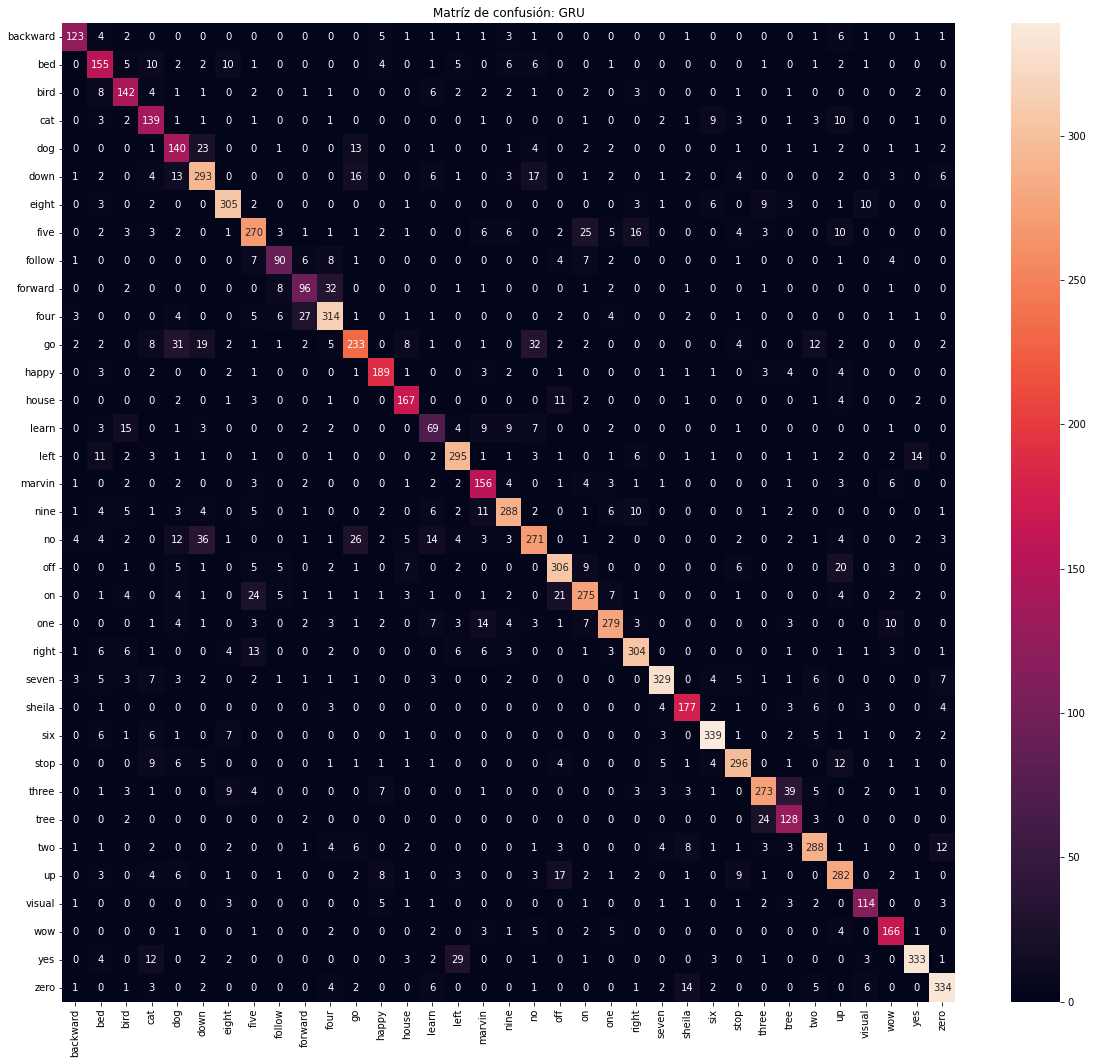

In [ ]:
project_utils.plot_conf_matrix(GRU_model, valid_loader, categories, name, DEVICE)

In [ ]:
name = "CUSTOM"
learning_rate = 3e-4
epochs = 50

hidden_size = 64
num_layers = 2

model = models.CustomLSTM(CHANNELS, hidden_size, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

train_loss_evolution, train_acc_evolution, val_acc_evolution, val_loss_evolution = project_utils.train_complete(model, criterion, optimizer, epochs, train_loader, valid_loader, name, DEVICE)

custom1_model = models.CustomLSTM(CHANNELS, hidden_size, NUM_CLASSES)
custom1_model.load_state_dict(torch.load(f'{name}.pt'))

Epoch: 01 | Epoch Time: 0m 16s
	Train Loss: 3.499 | Train Acc: 6.64%
	 Val. Loss: 3.499 |  Val. Acc: 6.64%
Epoch: 02 | Epoch Time: 0m 18s
	Train Loss: 3.409 | Train Acc: 12.92%
	 Val. Loss: 3.409 |  Val. Acc: 12.92%
Epoch: 03 | Epoch Time: 0m 14s
	Train Loss: 3.277 | Train Acc: 19.88%
	 Val. Loss: 3.277 |  Val. Acc: 19.89%
Epoch: 04 | Epoch Time: 0m 14s
	Train Loss: 3.129 | Train Acc: 26.17%
	 Val. Loss: 3.129 |  Val. Acc: 26.17%
Epoch: 05 | Epoch Time: 0m 14s
	Train Loss: 2.961 | Train Acc: 33.14%
	 Val. Loss: 2.961 |  Val. Acc: 33.15%
Epoch: 06 | Epoch Time: 0m 15s
	Train Loss: 2.781 | Train Acc: 37.90%
	 Val. Loss: 2.781 |  Val. Acc: 37.89%
Epoch: 07 | Epoch Time: 0m 14s
	Train Loss: 2.582 | Train Acc: 41.87%
	 Val. Loss: 2.582 |  Val. Acc: 41.88%
Epoch: 08 | Epoch Time: 0m 15s
	Train Loss: 2.405 | Train Acc: 46.58%
	 Val. Loss: 2.405 |  Val. Acc: 46.59%
Epoch: 09 | Epoch Time: 0m 15s
	Train Loss: 2.252 | Train Acc: 49.59%
	 Val. Loss: 2.252 |  Val. Acc: 49.58%
Epoch: 10 | Epoch Tim

<All keys matched successfully>

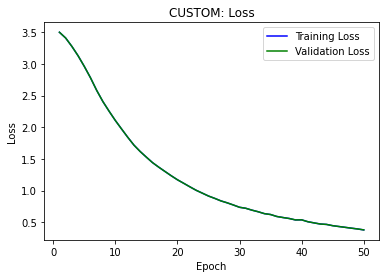

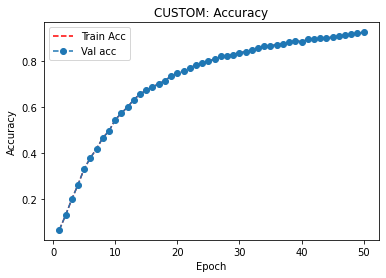

In [ ]:
project_utils.plot_train_evo(train_loss_evolution, val_loss_evolution, train_acc_evolution, val_acc_evolution, name)

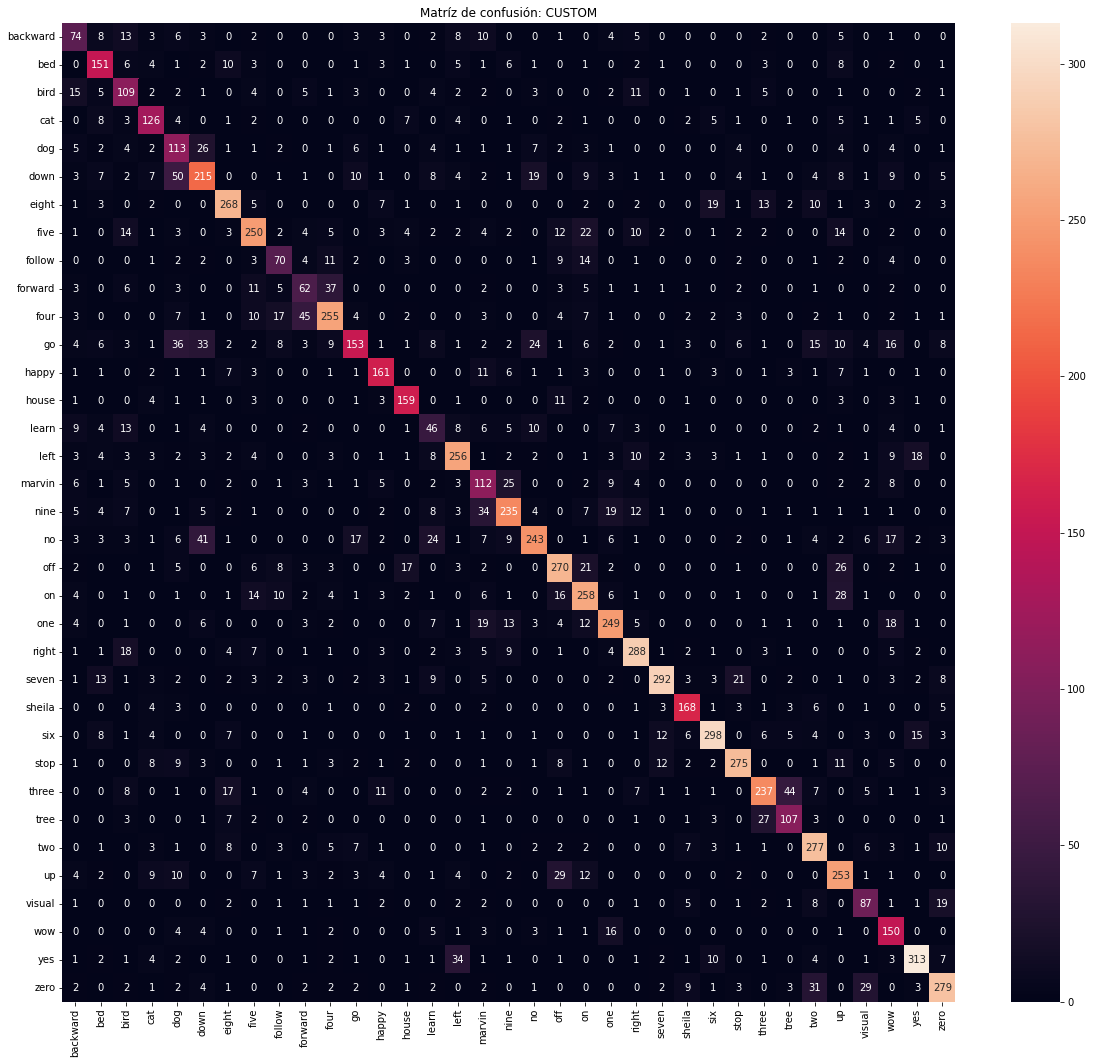

In [ ]:
project_utils.plot_conf_matrix(custom1_model, valid_loader, categories, name, DEVICE)

In [ ]:
name = "CustomPeepholeLSTM"
learning_rate = 3e-4
epochs = 50

hidden_size = 64
num_layers = 2
model = models.CustomPeepholeLSTM(CHANNELS, hidden_size, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

train_loss_evolution, train_acc_evolution, val_acc_evolution, val_loss_evolution = project_utils.train_complete(model, criterion, optimizer, epochs, train_loader, valid_loader, name, DEVICE)

custom2_model = models.CustomPeepholeLSTM(CHANNELS, hidden_size, NUM_CLASSES)
custom2_model.load_state_dict(torch.load(f'{name}.pt'))

Epoch: 01 | Epoch Time: 0m 18s
	Train Loss: 3.455 | Train Acc: 8.24%
	 Val. Loss: 3.455 |  Val. Acc: 8.24%
Epoch: 02 | Epoch Time: 0m 18s
	Train Loss: 3.302 | Train Acc: 16.08%
	 Val. Loss: 3.302 |  Val. Acc: 16.08%
Epoch: 03 | Epoch Time: 0m 19s
	Train Loss: 3.060 | Train Acc: 24.50%
	 Val. Loss: 3.060 |  Val. Acc: 24.50%
Epoch: 04 | Epoch Time: 0m 19s
	Train Loss: 2.796 | Train Acc: 33.59%
	 Val. Loss: 2.796 |  Val. Acc: 33.59%
Epoch: 05 | Epoch Time: 0m 24s
	Train Loss: 2.541 | Train Acc: 40.91%
	 Val. Loss: 2.541 |  Val. Acc: 40.90%
Epoch: 06 | Epoch Time: 0m 18s
	Train Loss: 2.298 | Train Acc: 48.94%
	 Val. Loss: 2.298 |  Val. Acc: 48.93%
Epoch: 07 | Epoch Time: 0m 18s
	Train Loss: 2.069 | Train Acc: 55.18%
	 Val. Loss: 2.069 |  Val. Acc: 55.19%
Epoch: 08 | Epoch Time: 0m 18s
	Train Loss: 1.864 | Train Acc: 60.21%
	 Val. Loss: 1.863 |  Val. Acc: 60.21%
Epoch: 09 | Epoch Time: 0m 19s
	Train Loss: 1.681 | Train Acc: 65.27%
	 Val. Loss: 1.681 |  Val. Acc: 65.28%
Epoch: 10 | Epoch Tim

<All keys matched successfully>

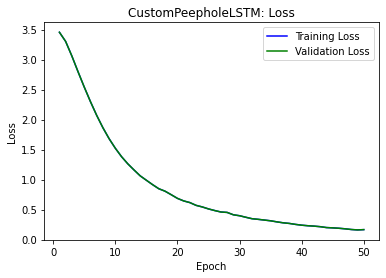

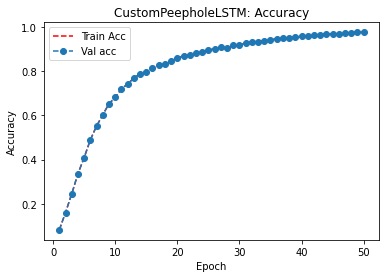

In [ ]:
project_utils.plot_train_evo(train_loss_evolution, val_loss_evolution, train_acc_evolution, val_acc_evolution, name)

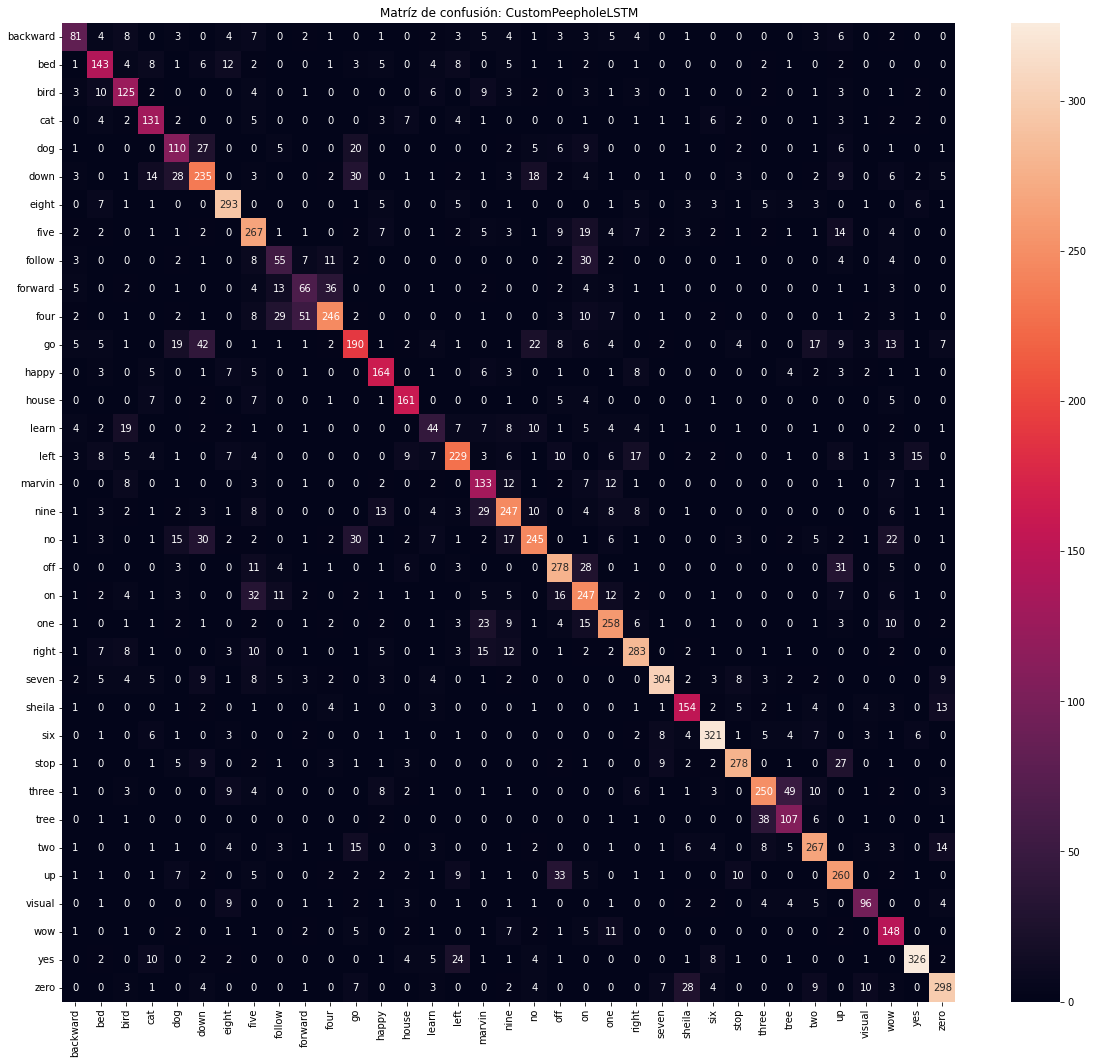

In [ ]:
project_utils.plot_conf_matrix(custom2_model, valid_loader, categories, name, DEVICE)

In [ ]:
name = "CustomCoupledGateLSTM"
learning_rate = 3e-4
epochs = 50

hidden_size = 64
num_layers = 2
model = models.CustomCoupledGateLSTM(CHANNELS, hidden_size, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

train_loss_evolution, train_acc_evolution, val_acc_evolution, val_loss_evolution = project_utils.train_complete(model, criterion, optimizer, epochs, train_loader, valid_loader, name, DEVICE)

custom3_model = models.CustomCoupledGateLSTM(CHANNELS, hidden_size, NUM_CLASSES)
custom3_model.load_state_dict(torch.load(f'{name}.pt'))

Epoch: 01 | Epoch Time: 0m 12s
	Train Loss: 3.429 | Train Acc: 13.52%
	 Val. Loss: 3.429 |  Val. Acc: 13.52%
Epoch: 02 | Epoch Time: 0m 12s
	Train Loss: 3.220 | Train Acc: 25.46%
	 Val. Loss: 3.220 |  Val. Acc: 25.47%
Epoch: 03 | Epoch Time: 0m 12s
	Train Loss: 2.961 | Train Acc: 35.74%
	 Val. Loss: 2.961 |  Val. Acc: 35.73%
Epoch: 04 | Epoch Time: 0m 13s
	Train Loss: 2.692 | Train Acc: 44.26%
	 Val. Loss: 2.692 |  Val. Acc: 44.27%
Epoch: 05 | Epoch Time: 0m 12s
	Train Loss: 2.443 | Train Acc: 52.19%
	 Val. Loss: 2.443 |  Val. Acc: 52.19%
Epoch: 06 | Epoch Time: 0m 12s
	Train Loss: 2.224 | Train Acc: 57.51%
	 Val. Loss: 2.224 |  Val. Acc: 57.51%
Epoch: 07 | Epoch Time: 0m 12s
	Train Loss: 2.038 | Train Acc: 61.50%
	 Val. Loss: 2.038 |  Val. Acc: 61.49%
Epoch: 08 | Epoch Time: 0m 12s
	Train Loss: 1.870 | Train Acc: 65.40%
	 Val. Loss: 1.870 |  Val. Acc: 65.40%
Epoch: 09 | Epoch Time: 0m 13s
	Train Loss: 1.722 | Train Acc: 68.20%
	 Val. Loss: 1.722 |  Val. Acc: 68.20%
Epoch: 10 | Epoch T

<All keys matched successfully>

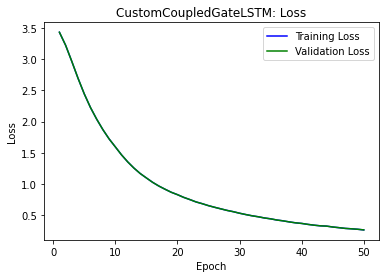

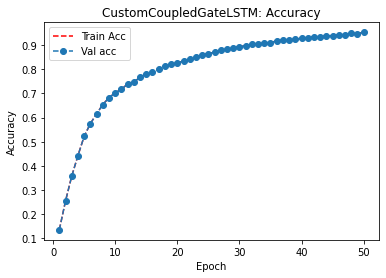

In [ ]:
project_utils.plot_train_evo(train_loss_evolution, val_loss_evolution, train_acc_evolution, val_acc_evolution, name)

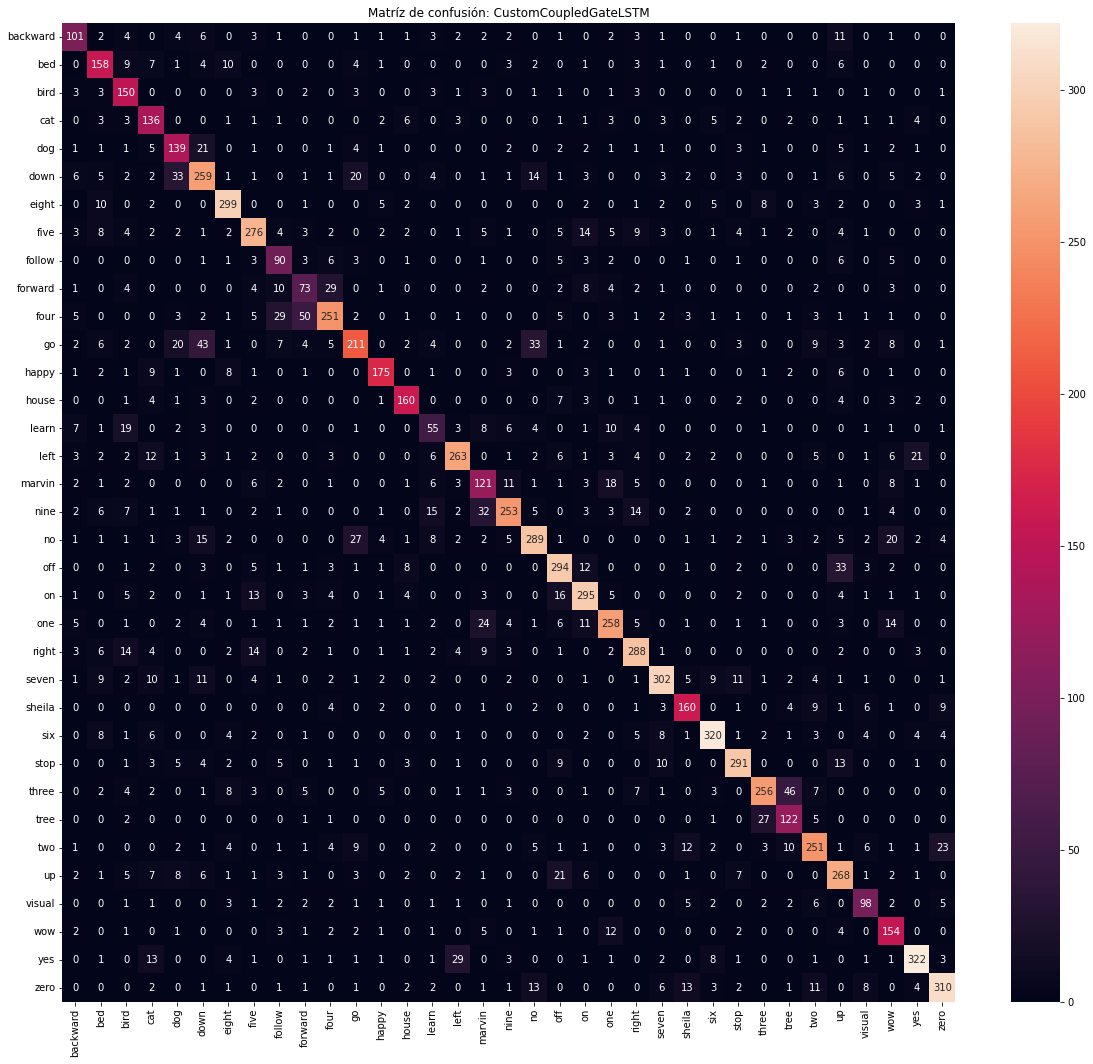

In [ ]:
project_utils.plot_conf_matrix(custom3_model, valid_loader, categories, name, DEVICE)

In [ ]:
name = "CustomNoForgetGateLSTM"
learning_rate = 3e-4
epochs = 50

hidden_size = 64
num_layers = 2
model = models.CustomNoForgetGateLSTM(CHANNELS, hidden_size, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

train_loss_evolution, train_acc_evolution, val_acc_evolution, val_loss_evolution = project_utils.train_complete(model, criterion, optimizer, epochs, train_loader, valid_loader, name, DEVICE)

custom4_model = models.CustomNoForgetGateLSTM(CHANNELS, hidden_size, NUM_CLASSES)
custom4_model.load_state_dict(torch.load(f'{name}.pt'))

Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 3.397 | Train Acc: 11.90%
	 Val. Loss: 3.397 |  Val. Acc: 11.90%
Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 3.203 | Train Acc: 21.77%
	 Val. Loss: 3.203 |  Val. Acc: 21.77%
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 2.974 | Train Acc: 30.48%
	 Val. Loss: 2.974 |  Val. Acc: 30.47%
Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 2.729 | Train Acc: 40.60%
	 Val. Loss: 2.729 |  Val. Acc: 40.60%
Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 2.482 | Train Acc: 47.41%
	 Val. Loss: 2.482 |  Val. Acc: 47.40%
Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 2.261 | Train Acc: 52.24%
	 Val. Loss: 2.261 |  Val. Acc: 52.25%
Epoch: 07 | Epoch Time: 0m 11s
	Train Loss: 2.033 | Train Acc: 58.21%
	 Val. Loss: 2.032 |  Val. Acc: 58.22%
Epoch: 08 | Epoch Time: 0m 11s
	Train Loss: 1.821 | Train Acc: 63.05%
	 Val. Loss: 1.821 |  Val. Acc: 63.05%
Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 1.649 | Train Acc: 66.35%
	 Val. Loss: 1.649 |  Val. Acc: 66.36%
Epoch: 10 | Epoch T

<All keys matched successfully>

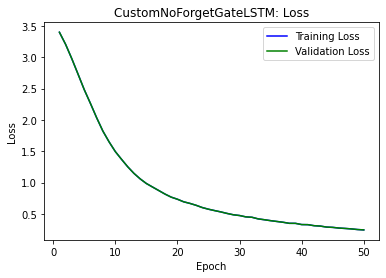

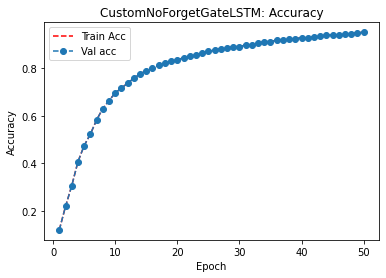

In [ ]:
project_utils.plot_train_evo(train_loss_evolution, val_loss_evolution, train_acc_evolution, val_acc_evolution, name)

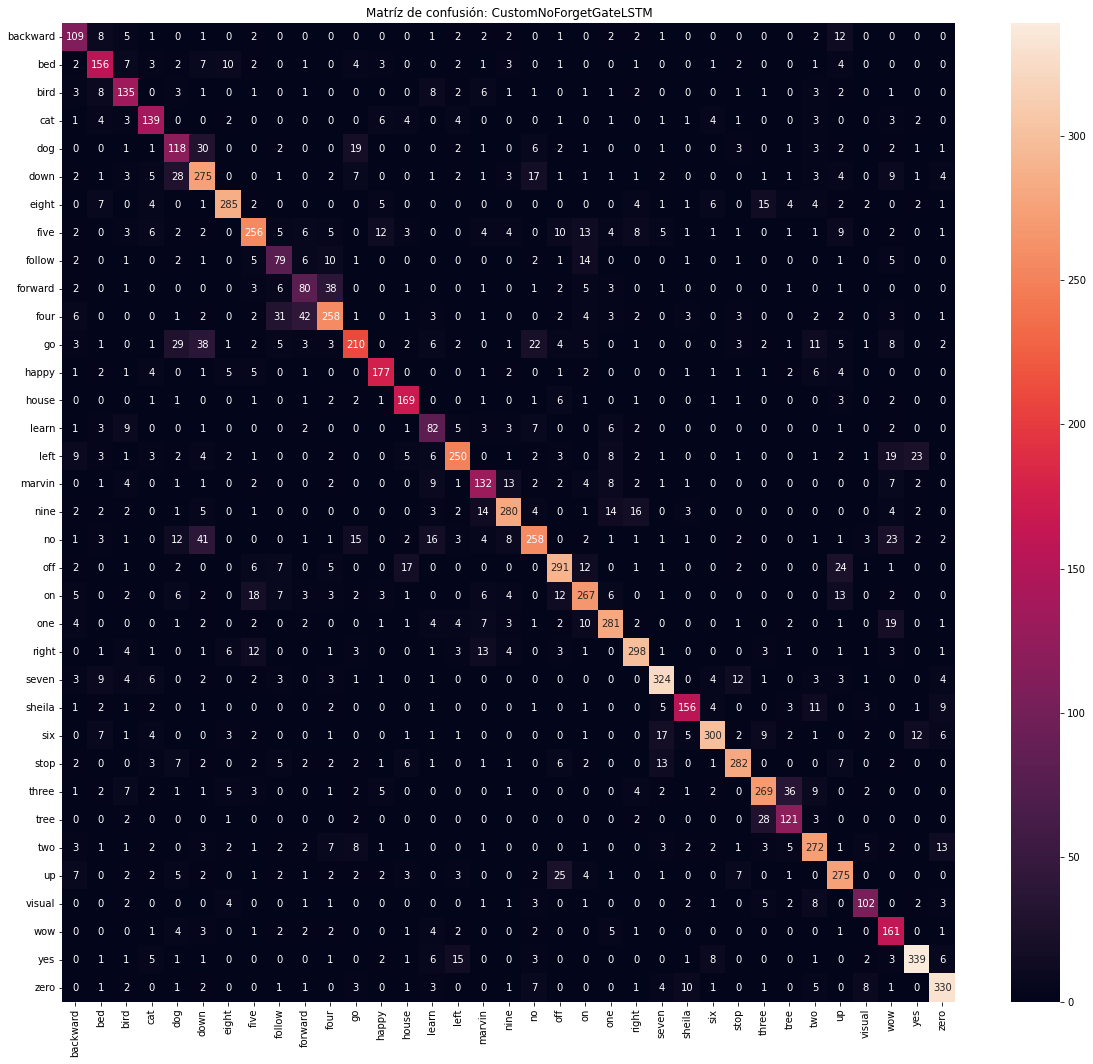

In [ ]:
project_utils.plot_conf_matrix(custom4_model, valid_loader, categories, name, DEVICE)

In [ ]:
name = "CustomNoInputGateLSTM"
learning_rate = 3e-4
epochs = 50

hidden_size = 64
num_layers = 2
model = models.CustomNoInputGateLSTM(CHANNELS, hidden_size, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

train_loss_evolution, train_acc_evolution, val_acc_evolution, val_loss_evolution = project_utils.train_complete(model, criterion, optimizer, epochs, train_loader, test_loader, name, DEVICE)

custom5_model = models.CustomNoInputGateLSTM(CHANNELS, hidden_size, NUM_CLASSES)
custom5_model.load_state_dict(torch.load(f'{name}.pt'))

Epoch: 01 | Epoch Time: 0m 12s
	Train Loss: 3.511 | Train Acc: 5.61%
	 Val. Loss: 3.511 |  Val. Acc: 5.61%
Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 3.459 | Train Acc: 7.63%
	 Val. Loss: 3.459 |  Val. Acc: 7.63%
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 3.399 | Train Acc: 10.20%
	 Val. Loss: 3.399 |  Val. Acc: 10.21%
Epoch: 04 | Epoch Time: 0m 12s
	Train Loss: 3.322 | Train Acc: 13.66%
	 Val. Loss: 3.322 |  Val. Acc: 13.66%
Epoch: 05 | Epoch Time: 0m 12s
	Train Loss: 3.240 | Train Acc: 16.13%
	 Val. Loss: 3.240 |  Val. Acc: 16.14%
Epoch: 06 | Epoch Time: 0m 12s
	Train Loss: 3.160 | Train Acc: 18.60%
	 Val. Loss: 3.160 |  Val. Acc: 18.61%
Epoch: 07 | Epoch Time: 0m 11s
	Train Loss: 3.081 | Train Acc: 20.14%
	 Val. Loss: 3.081 |  Val. Acc: 20.13%
Epoch: 08 | Epoch Time: 0m 12s
	Train Loss: 3.002 | Train Acc: 22.60%
	 Val. Loss: 3.002 |  Val. Acc: 22.60%
Epoch: 09 | Epoch Time: 0m 12s
	Train Loss: 2.928 | Train Acc: 24.12%
	 Val. Loss: 2.928 |  Val. Acc: 24.13%
Epoch: 10 | Epoch Time:

<All keys matched successfully>

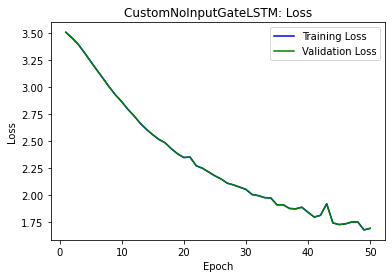

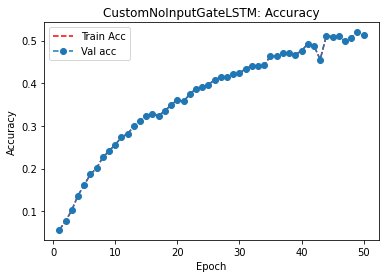

In [ ]:
project_utils.plot_train_evo(train_loss_evolution, val_loss_evolution, train_acc_evolution, val_acc_evolution, name)

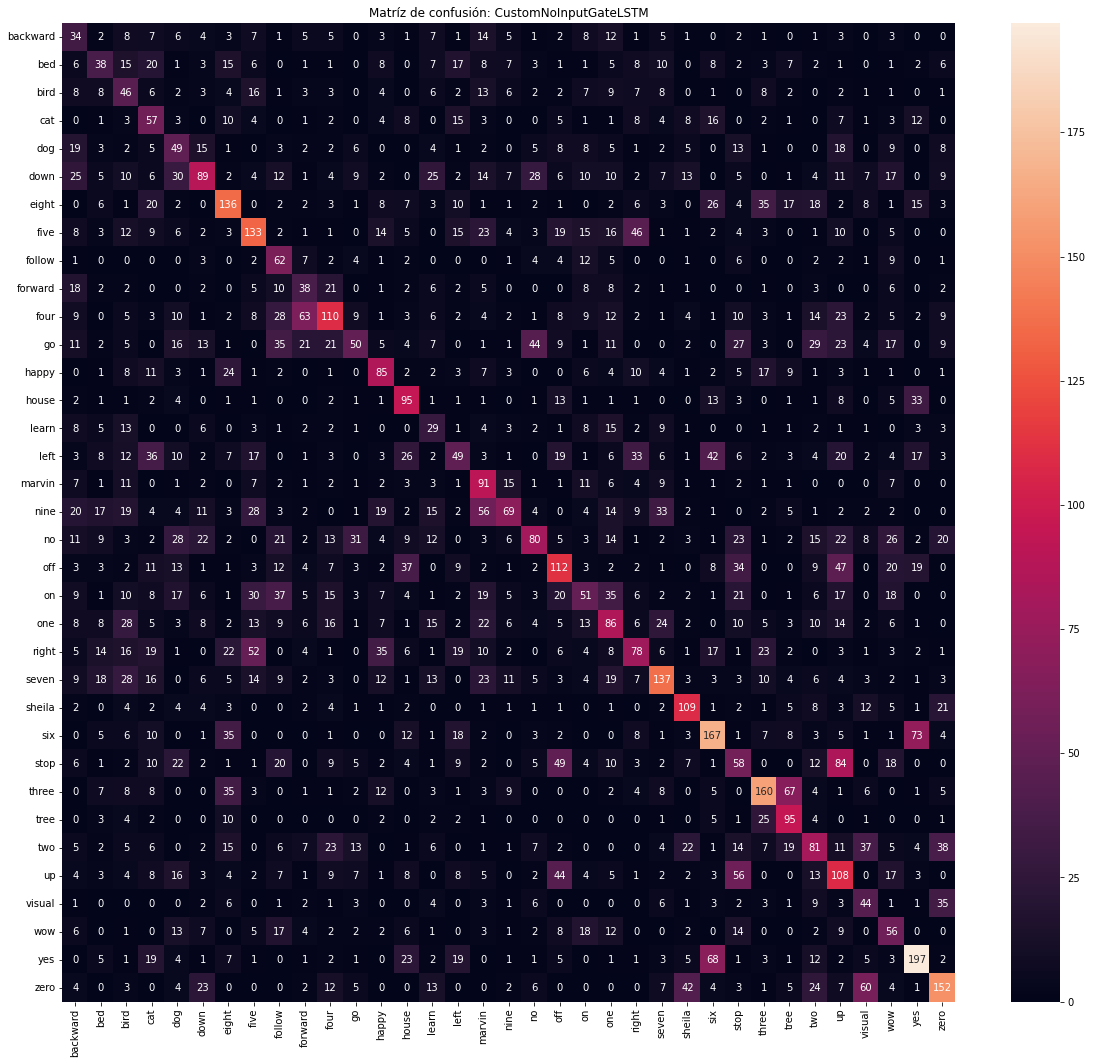

In [ ]:
project_utils.plot_conf_matrix(custom5_model, valid_loader, categories, name, DEVICE)

In [ ]:
name = "CustomNoOutputGateLSTM"
learning_rate = 3e-4
epochs = 50

hidden_size = 64
num_layers = 2
model = models.CustomNoOutputGateLSTM(CHANNELS, hidden_size, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

train_loss_evolution, train_acc_evolution, val_acc_evolution, val_loss_evolution = project_utils.train_complete(model, criterion, optimizer, epochs, train_loader, test_loader, name, DEVICE)

custom6_model = models.CustomNoOutputGateLSTM(CHANNELS, hidden_size, NUM_CLASSES)
custom6_model.load_state_dict(torch.load(f'{name}.pt'))

Epoch: 01 | Epoch Time: 0m 11s
	Train Loss: 3.426 | Train Acc: 9.93%
	 Val. Loss: 3.426 |  Val. Acc: 9.93%
Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 3.286 | Train Acc: 16.32%
	 Val. Loss: 3.286 |  Val. Acc: 16.32%
Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 3.113 | Train Acc: 23.93%
	 Val. Loss: 3.113 |  Val. Acc: 23.93%
Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 2.937 | Train Acc: 29.95%
	 Val. Loss: 2.937 |  Val. Acc: 29.94%
Epoch: 05 | Epoch Time: 0m 11s
	Train Loss: 2.744 | Train Acc: 36.87%
	 Val. Loss: 2.744 |  Val. Acc: 36.87%
Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 2.559 | Train Acc: 42.16%
	 Val. Loss: 2.559 |  Val. Acc: 42.16%
Epoch: 07 | Epoch Time: 0m 11s
	Train Loss: 2.372 | Train Acc: 47.94%
	 Val. Loss: 2.372 |  Val. Acc: 47.94%
Epoch: 08 | Epoch Time: 0m 11s
	Train Loss: 2.206 | Train Acc: 52.01%
	 Val. Loss: 2.206 |  Val. Acc: 52.01%
Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 2.038 | Train Acc: 56.01%
	 Val. Loss: 2.038 |  Val. Acc: 56.01%
Epoch: 10 | Epoch Tim

<All keys matched successfully>

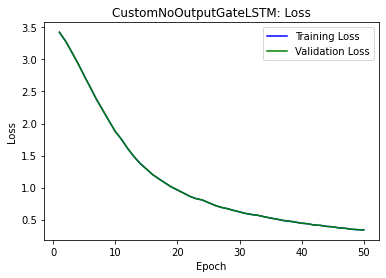

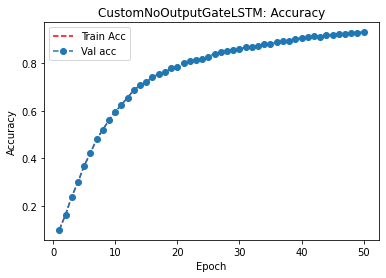

In [ ]:
project_utils.plot_train_evo(train_loss_evolution, val_loss_evolution, train_acc_evolution, val_acc_evolution, name)

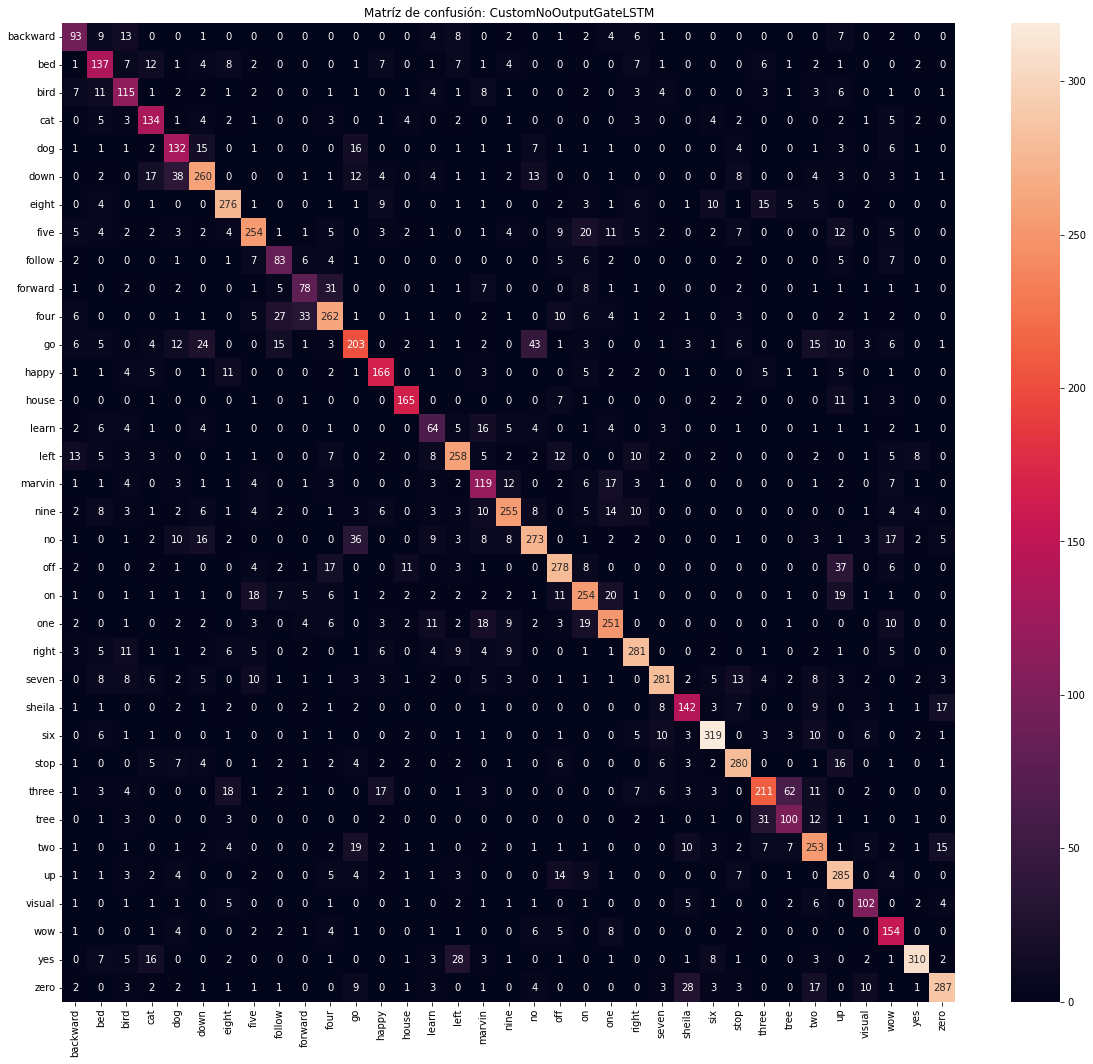

In [ ]:
project_utils.plot_conf_matrix(custom6_model, valid_loader, categories, name, DEVICE)

In [ ]:
import matplotlib.pyplot as plt

def plot_train_evo(train_loss, val_loss, train_acc, val_acc, name, desc):
  # Create count of the number of epochs
  epoch_count = range(1, len(train_loss) + 1)

  # Visualize loss history
  plt.figure(figsize=(16,12))
  plt.plot(epoch_count, train_loss, 'b-')
  plt.plot(epoch_count, val_loss, 'g-')
  plt.legend(['Training Loss', 'Validation Loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(name + ": Loss")
  plt.savefig(f'{name}loss_{desc}.png')
  plt.show()

  plt.figure(figsize=(16,12))
  plt.plot(epoch_count, train_acc, 'r--')
  plt.plot(epoch_count, val_acc, 'o--')
  plt.legend(['Train Acc', 'Val acc'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title(name + ": Accuracy")
  plt.savefig(f'{name}acc_{desc}.png')
  plt.show()

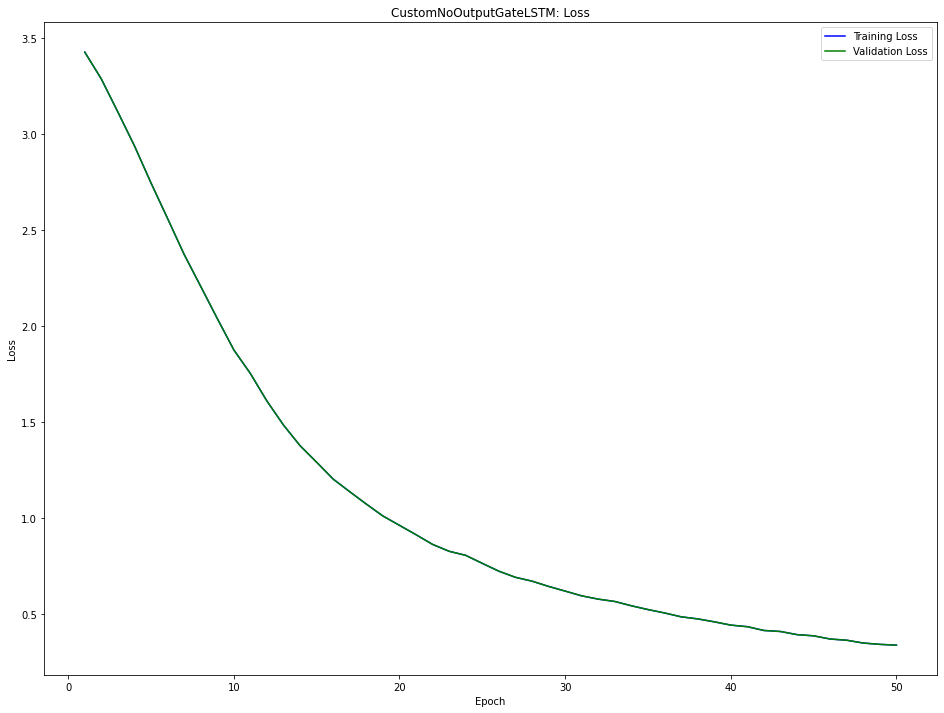

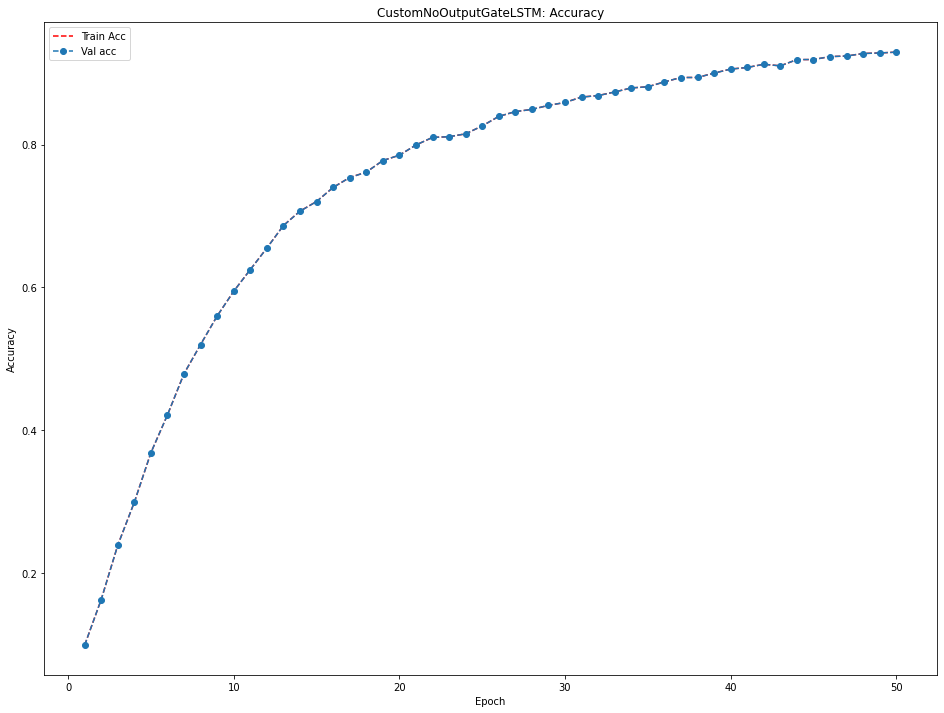

In [ ]:
plot_train_evo(train_loss_evolution, val_loss_evolution, train_acc_evolution, val_acc_evolution, name, "ejemplo")

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_conf_matrix(model, valid_loader, categories, name, desc, device):
  model = model.to(device)
  yh = []
  ys = []
  for i, (audios, labels) in enumerate(valid_loader):
    audios = audios.to(device)
    labels = labels.to(device)
    y_hat = model(audios)
    y_hat = y_hat.argmax(1)
    y = labels
    yh = yh + y_hat.tolist()
    ys = ys + y.tolist()
    
  df_cm = pd.DataFrame(confusion_matrix(ys, yh), index = categories,
                    columns = categories)
  plt.figure(figsize = (20,18))
  plt.title("Matríz de confusión: "+ name)
  sns_plot = sns.heatmap(df_cm, annot=True, fmt='g')
  sns_plot.figure.savefig(f'{name}confmat_{desc}.png')

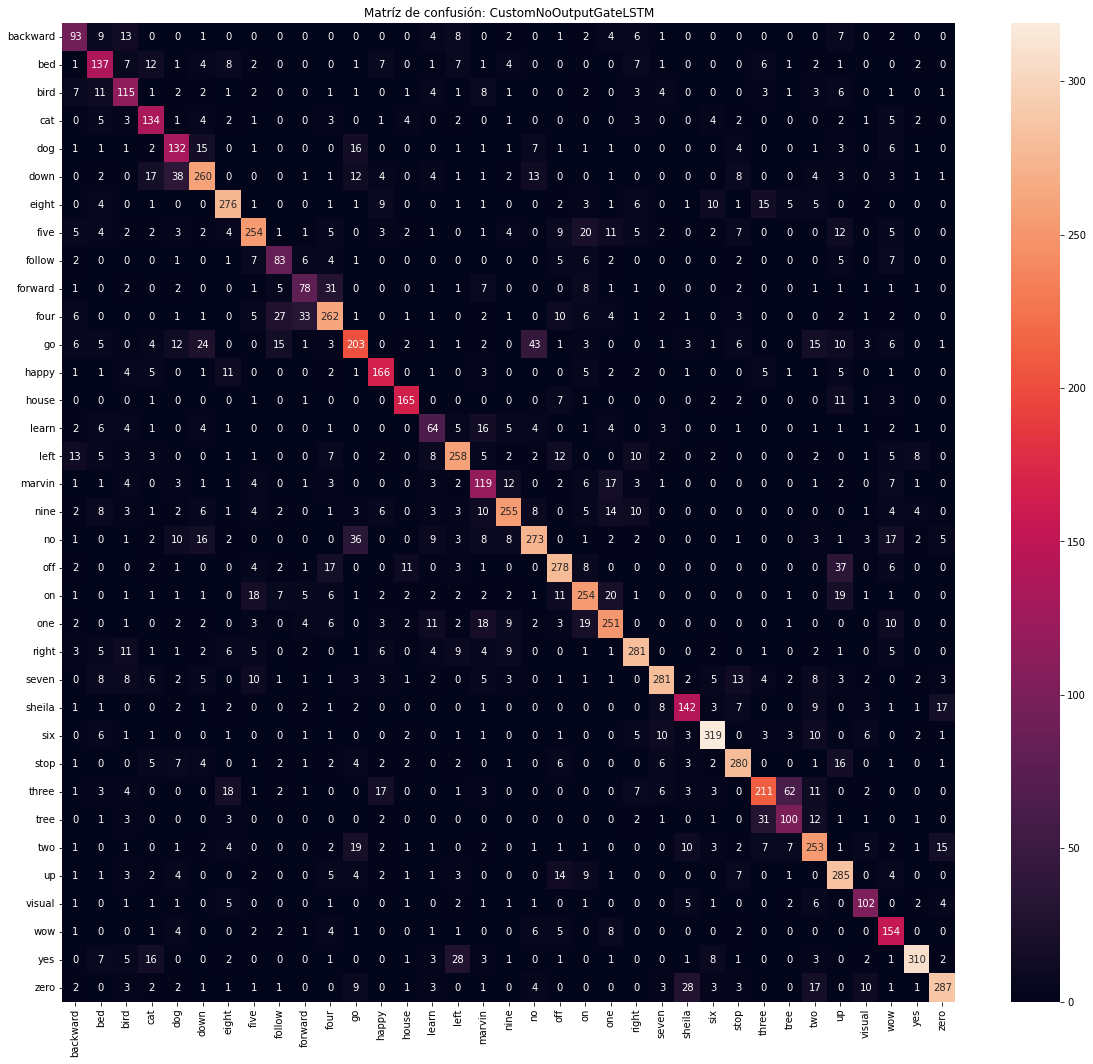

In [ ]:
plot_conf_matrix(custom6_model, valid_loader, categories, name, "ejemplo", DEVICE)

In [ ]:
from unicodedata import bidirectional
class RNN(nn.Module):
    def __init__(self, hidden_size, num_layers, num_classes, input_size, sequence_len, bidirect):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.batchNorm = nn.BatchNorm1d(sequence_len)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout=0.2,  batch_first=True, bidirectional=bidirect)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        hidden = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(DEVICE)
        x = self.batchNorm(x)
        out, hidden = self.rnn(x, hidden)
        out = out[:, -1, :]
        out = self.fc(out)
        return out